## 数字识别

* 有监督；
* 分类问题；
* 训练数据集：对应数字以及每个位置的像素点组成；
* 测试数据集：每个位置的像素点；
* 提交格式：ImageId,Label；

## 初始化环境

In [29]:
import os,sys,time
from datetime import datetime
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

from scipy.stats import probplot
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

SEED = 9291

%matplotlib inline

## 加载、展示数据，内存优化

In [2]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data, train_size=42000):
    # Returns divided dfs of training and test set
    return all_data.loc[:train_size-1], all_data.loc[train_size:].drop(['label'], axis=1)

### 加载

In [3]:
train_data = pd.read_csv('input/train.csv')
print train_data.info(memory_usage='deep')

test_data = pd.read_csv('input/test.csv')
print test_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None


784=28*28，即每张数字图是28*28的格式；

In [4]:
all_data = concat_df(train_data, test_data)

### 内存优化

In [5]:
all_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 785 entries, label to pixel99
dtypes: float64(1), int64(784)
memory usage: 419.2 MB


In [6]:
all_data = all_data.apply(pd.to_numeric,downcast='unsigned')
all_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 785 entries, label to pixel99
dtypes: float64(1), uint8(784)
memory usage: 52.9 MB


### 展示

In [7]:
all_data.sample(10)

,label,pixel0,pixel1,pixel10,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,...,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99
22409,8.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2640,7.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26278,7.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50703,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7549,7.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15644,5.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2504,9.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20653,7.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30104,7.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34845,3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
train_data[['label','pixel0']].groupby('label').count()

,pixel0
label,
0,4132
1,4684
2,4177
3,4351
4,4072
5,3795
6,4137
7,4401
8,4063


看到各个数字对应的训练数据个数相差不大，基本都在4000左右，比较平衡；

## 可视化特征

观察任意两组数据的标准差方差比较；

In [9]:
train_data.groupby('label').std().mean(axis=1)

label
0    44.810023
1    24.077799
2    47.097188
3    43.168668
4    40.773742
5    44.821169
6    40.953832
7    38.045724
8    42.534838
9    37.799291
dtype: float64

In [10]:
train_data[train_data['label']%4==0].std().mean()

48.453327804548906

看到std有明显增高，说明各个分类之间的差异是明显的；

## 数据预处理

- 缺失处理；
- 异常处理；

## 特征工程

同样的，因为是像素数据，不好直接直接特征构建、选择等，不过可以将全是0的特征去除，这些特征明显无法起到帮助作用（即方差过滤法的简单形式）；

0. 方差过滤法；
1. 每组数据都是一个N\*M的分辨率图片的每个像素点，那么可以找到每一行1的个数，每一列1的个数；
2. 1的总数；

### 构建28*28图的每行不为0的总数特征

In [11]:
# 28行
for i in range(28):
    cols = [col for col in all_data.columns if col != 'label' and col.find('pixel')!=-1 and int(int(col.replace('pixel',''))/28)==i]
    all_data['row_'+str(i+1)] = all_data[cols].apply(lambda x: sum([0 if t==0 else 1 for t in x]), axis=1)

all_data[[col for col in all_data.columns if col.find('row_')!=-1]].sample(3)

,row_1,row_2,row_3,row_4,row_5,row_6,row_7,row_8,row_9,row_10,...,row_19,row_20,row_21,row_22,row_23,row_24,row_25,row_26,row_27,row_28
65396,0,0,0,0,3,3,4,4,3,3,...,3,5,5,5,5,3,0,0,0,0
26577,0,0,0,0,0,9,10,11,8,5,...,4,5,5,6,7,9,9,0,0,0
38544,0,0,0,0,3,4,5,5,4,4,...,5,7,9,6,5,5,0,0,0,0


### 构建28*28图的每列1的总数特征

In [12]:
# 28列
for i in range(28):
    cols = [col for col in all_data.columns if col != 'label' and col.find('pixel')!=-1 and int(int(col.replace('pixel',''))%28)==i]
    all_data['col_'+str(i+1)] = all_data[cols].apply(lambda x: sum([0 if t==0 else 1 for t in x]), axis=1)

all_data[[col for col in all_data.columns if col.find('col_')!=-1]].sample(3)

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,...,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28
28196,0,0,0,0,4,6,6,6,7,9,...,8,10,11,8,8,6,0,0,0,0
35590,0,0,0,0,6,8,10,12,10,9,...,8,10,13,12,9,3,0,0,0,0
51871,0,0,0,0,0,0,0,0,9,12,...,9,8,9,8,6,5,0,0,0,0


### 构建28*28图的1的总数特征

In [13]:
# 28×28
cols = [col for col in all_data.columns if col != 'label' and col.find('pixel')!=-1]
all_data['all_image'] = all_data[cols].apply(lambda x: sum([0 if t==0 else 1 for t in x]), axis=1)

all_data[['all_image','label']].sample(10)

,all_image,label
35655,228,0.0
17619,184,6.0
41637,157,0.0
45298,121,NaN
1756,164,8.0
2166,172,2.0
49095,152,NaN
65117,229,NaN
36784,149,6.0
54442,155,NaN


### 过滤掉全是0的列

In [14]:
all_zero_columns = []
for col in all_data.columns:
    if 0 >= all_data[col].max():
        all_zero_columns.append(col)
print all_zero_columns

['pixel0', 'pixel1', 'pixel10', 'pixel11', 'pixel111', 'pixel112', 'pixel140', 'pixel16', 'pixel168', 'pixel17', 'pixel18', 'pixel19', 'pixel2', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel3', 'pixel30', 'pixel31', 'pixel4', 'pixel476', 'pixel5', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel560', 'pixel57', 'pixel6', 'pixel644', 'pixel671', 'pixel672', 'pixel673', 'pixel699', 'pixel7', 'pixel700', 'pixel701', 'pixel727', 'pixel728', 'pixel729', 'pixel730', 'pixel754', 'pixel755', 'pixel756', 'pixel757', 'pixel758', 'pixel759', 'pixel780', 'pixel781', 'pixel782', 'pixel783', 'pixel8', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel9']


In [15]:
all_data.drop(all_zero_columns, axis=1, inplace=True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 777 entries, label to all_image
dtypes: float64(1), int64(57), uint8(719)
memory usage: 79.0 MB


### 方差过滤

In [16]:
print len(all_data.columns)

777


In [17]:
# 过滤掉方差小于0.1的特征
threshold = .8*(1-.8)
all_data_without_target = all_data.drop(['label'], axis=1)
selector = VarianceThreshold(threshold=threshold).fit(all_data_without_target)

for feature,variance in zip(list(all_data_without_target.columns),selector.variances_):
    print feature, variance, variance>=threshold
    if variance < threshold:
        all_data.drop(feature, axis=1, inplace=True)

pixel100 2475.481296482449 True
pixel101 2220.1317095426534 True
pixel102 1804.1300272653061 True
pixel103 1309.3671964081632 True
pixel104 785.4129124171432 True
pixel105 430.52276553061216 True
pixel106 192.84726855102042 True
pixel107 76.41804083244898 True
pixel108 28.15855856632653 True
pixel109 3.8632425124489793 True
pixel110 0.6202490691836736 True
pixel113 0.020628276734693873 False
pixel114 0.38702286346938763 True
pixel115 1.0269039997959186 True
pixel116 12.143777370612247 True
pixel117 61.49446267346941 True
pixel118 172.4656764538776 True
pixel119 435.5346495640818 True
pixel12 0.19365390285714287 True
pixel120 884.0021983477551 True
pixel121 1587.8409816326532 True
pixel122 2537.9635518824493 True
pixel123 3670.89860730102 True
pixel124 4890.936816959999 True
pixel125 6140.921724489795 True
pixel126 7094.081583301222 True
pixel127 7531.423256632653 True
pixel128 7344.328434194081 True
pixel129 6585.10996676551 True
pixel13 1.5881263469387745 True
pixel130 5414.4543337712

pixel505 0.827259586734694 True
pixel506 30.220998158163265 True
pixel507 276.09655297959193 True
pixel508 1435.9453970267346 True
pixel509 3829.9293768928574 True
pixel51 0.5576193991836735 True
pixel510 6280.822834506937 True
pixel511 8127.260040519185 True
pixel512 9294.752111474285 True
pixel513 10052.36077053959 True
pixel514 10589.188263996735 True
pixel515 11008.94966386204 True
pixel516 11350.244244701222 True
pixel517 11931.774565206326 True
pixel518 12356.54596591347 True
pixel519 12326.102214035713 True
pixel520 12174.245917253878 True
pixel521 12164.760281142857 True
pixel522 11951.814957706938 True
pixel523 11054.17585598694 True
pixel524 9157.733754918367 True
pixel525 6658.416711111021 True
pixel526 4157.996156626735 True
pixel527 2100.435613586939 True
pixel528 811.7112088155103 True
pixel529 225.48385525693874 True
pixel530 24.446143346938776 True
pixel531 1.4812301583673468 True
pixel532 0.003214239795918368 False
pixel533 1.928487306938775 True
pixel534 50.1749395083

col_2 0.014277909999999998 False
col_3 0.11765147571428572 False
col_4 0.6522393712244896 True
col_5 2.7404003134693884 True
col_6 7.326493668367346 True
col_7 12.745799964081632 True
col_8 17.326092852040816 True
col_9 19.18812307265306 True
col_10 18.86561511 True
col_11 18.198410097755104 True
col_12 17.406080019591837 True
col_13 15.251088391020408 True
col_14 14.925828269183672 True
col_15 15.347472979591837 True
col_16 14.559515836734692 True
col_17 15.66939413857143 True
col_18 19.99993540387755 True
col_19 22.389265586938773 True
col_20 23.173883819591836 True
col_21 22.183469706938777 True
col_22 18.46278354265306 True
col_23 12.832311206326533 True
col_24 7.080537244081633 True
col_25 2.797035018571428 True
col_26 0.6090172726530613 True
col_27 0.09647771102040814 False
col_28 0.006463508367346938 False
all_image 1718.990118239796 True


In [18]:
print len(all_data.columns)

739


### 数据转换

对col和row的非0统计特征做boxcox转换，注意只转换其中skew大于0.5的特征；

['row_3', 'row_4', 'row_5', 'row_6', 'row_7', 'row_8', 'row_9', 'row_10', 'row_11', 'row_12', 'row_13', 'row_14', 'row_15', 'row_16', 'row_17', 'row_18', 'row_19', 'row_20', 'row_21', 'row_22', 'row_23', 'row_24', 'row_25', 'row_26', 'row_27', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_15', 'col_16', 'col_17', 'col_18', 'col_19', 'col_20', 'col_21', 'col_22', 'col_23', 'col_24', 'col_25', 'col_26']
{'row_27': 2.981469912214193, 'row_26': 1.7719404186254784, 'row_25': 0.9059443901254033, 'row_22': 0.5437953087978591, 'row_21': 0.7178139059262578, 'row_20': 0.9199890618823419, 'col_8': 0.5649760942960462, 'col_6': 1.664798511975521, 'col_7': 1.0287443889546453, 'col_4': 5.356391235432634, 'col_5': 2.899673760295979, 'col_23': 1.3296413812344912, 'col_22': 0.8255696142792897, 'col_25': 2.8977246414744933, 'col_24': 1.9583042988433603, 'col_26': 4.928864524989308, 'row_16': 0.5489130574396769, 'row_17': 0.6718294946609397, '

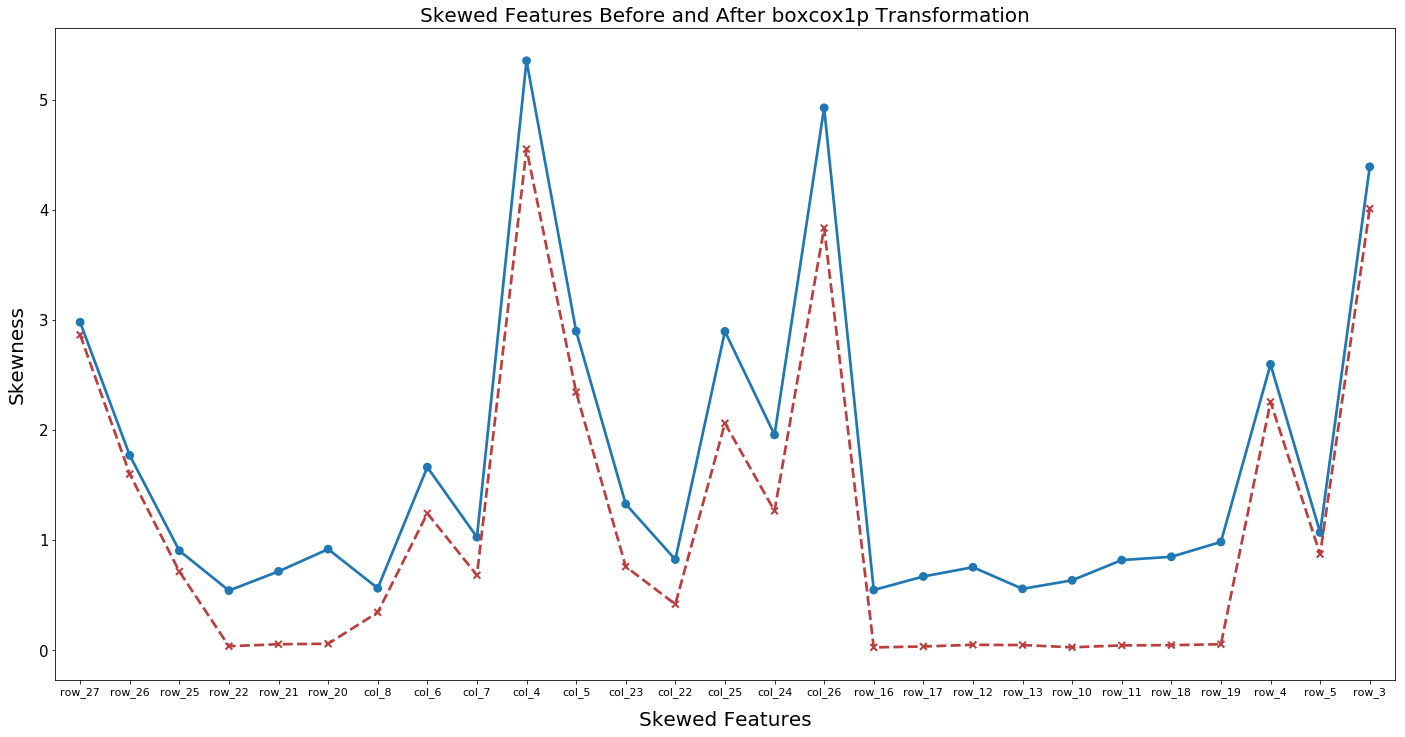

In [32]:
cont_features = [col for col in all_data.columns if col.find('col')!=-1 or col.find('row')!=-1]
print cont_features

skewed_features = {feature: all_data[feature].skew() for feature in cont_features if all_data[feature].skew() >= .5}
transformed_skews = {}
print skewed_features

for feature in skewed_features.keys():
    all_data[feature] = boxcox1p(all_data[feature], boxcox_normmax(all_data[feature] + 1))
    transformed_skews[feature] = all_data[feature].skew()
    
df_skew = pd.DataFrame(index=skewed_features.keys(), columns=['Skew', 'Skew after boxcox1p'])
df_skew['Skew'] = skewed_features.values()
df_skew['Skew after boxcox1p'] = transformed_skews.values()

fig = plt.figure(figsize=(24, 12))

sns.pointplot(x=df_skew.index, y='Skew', data=df_skew, markers=['o'], linestyles=['-'])
sns.pointplot(x=df_skew.index, y='Skew after boxcox1p', data=df_skew, markers=['x'], linestyles=['--'], color='#bb3f3f')

plt.xlabel('Skewed Features', size=20, labelpad=12.5)
plt.ylabel('Skewness', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=15)

plt.title('Skewed Features Before and After boxcox1p Transformation', size=20)

plt.show()

## 划分数据集

In [33]:
train_data, test_data = divide_df(all_data)

In [34]:
from sklearn.model_selection import train_test_split

x,y = train_data.drop(['label'], axis=1),train_data['label']
x_train,x_valid,y_train,y_valid = train_test_split(x,y,test_size=0.3,random_state=0)

x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29400 entries, 26437 to 2732
Columns: 738 entries, pixel100 to all_image
dtypes: float64(27), int64(22), uint8(689)
memory usage: 30.5 MB


## 模型构建、优化

In [35]:
train_x = train_data.drop('label', axis=1)
train_y = train_data['label']

In [36]:
K = 10
kf = model_selection.KFold(n_splits=K, shuffle=True, random_state=SEED)

def cv_score(model, X=train_x, y=train_y):
    return model_selection.cross_val_score(model, X, y, cv=kf)

### kNN - 0.9659

此问题虽然数据量不算小但是也不大，最简单的方法就是利用kNN，且kNN的一个好处是目前所有特征我们可以假设其权重一致，且分类平均，个类别差异较大，可以看到效果已经很好了，但是我们也知道一方面提升很困难，对于kNN除了修改k、距离公式（将特征权重改变）没有太多其他办法，同时算法运行时间比较长也是kNN的弊端，后面需要优化只能通过换其他算法；

In [37]:
from sklearn.neighbors import KNeighborsClassifier as kNN

    from sklearn.neighbors import KNeighborsClassifier as kNN

    knn = kNN()
    score = cv_score(knn, X=train_x, y=train_y)
    print 'Accuracy mean:'+str(score.mean())+', std:'+str(score.std())

### 多模型

最好得分为XGBT的0.97，最差为Adaboost的0.85；

In [40]:
models = {
    'Adaboost':ensemble.AdaBoostClassifier(n_estimators=500, learning_rate=.1), 
    'RandomForest':ensemble.RandomForestClassifier(n_estimators=200, n_jobs=-1, max_features = "sqrt", min_samples_split = 5),
    'kNN':kNN(),
    'XGBClassifier':XGBClassifier(n_estimators=500, n_jobs=-1),
    'LogisticRegression':linear_model.LogisticRegressionCV()
}

predictions = {}
scores = {}

for name, model in models.items():
    start = datetime.now()
    print('[{}] Running {}'.format(start, name))
    
    model.fit(train_x, train_y)
    predictions[name] = model.predict(train_x)
    
    score = cv_score(model, X=train_x, y=train_y)
    scores[name] = (score.mean(), score.std())
    
    end = datetime.now()
    
    print('[{}] Finished Running {} in {:.2f}s'.format(end, name, (end - start).total_seconds()))
    print('[{}] {} Mean Accuracy: {:.6f} / Std: {:.6f}\n'.format(datetime.now(), name, scores[name][0], scores[name][1]))

[2019-09-29 00:00:23.982252] Running kNN
[2019-09-29 01:19:24.184414] Finished Running kNN in 4740.20s
[2019-09-29 01:19:24.184528] kNN Mean Accuracy: 0.967619 / Std: 0.001714

[2019-09-29 01:19:24.184824] Running XGBClassifier
[2019-09-29 04:24:27.089905] Finished Running XGBClassifier in 11102.91s
[2019-09-29 04:24:27.090036] XGBClassifier Mean Accuracy: 0.972405 / Std: 0.002427

[2019-09-29 04:24:27.090084] Running RandomForest
[2019-09-29 04:28:30.148954] Finished Running RandomForest in 243.06s
[2019-09-29 04:28:30.149423] RandomForest Mean Accuracy: 0.966000 / Std: 0.002843

[2019-09-29 04:28:30.150285] Running LogisticRegression
[2019-09-29 06:27:18.175634] Finished Running LogisticRegression in 7128.03s
[2019-09-29 06:27:18.176103] LogisticRegression Mean Accuracy: 0.913857 / Std: 0.004938

[2019-09-29 06:27:18.176303] Running Adaboost
[2019-09-29 07:08:58.776568] Finished Running Adaboost in 2500.60s
[2019-09-29 07:08:58.776681] Adaboost Mean Accuracy: 0.850381 / Std: 0.005570

In [41]:
for k,v in models.items():
    joblib.dump(v, 'model/'+k+'.model')

### 模型融合

- 投票法；
- 加权融合；
- 元模型融合；

#### 定义投票方法

In [42]:
def vota(results, weights=None):
    vota_results = []
    if weights == None:
        weights = [1]*len(results)
    for i in range(len(train_x)):
        votas = {}
        for j in range(len(models.keys())):
            votas[results[j][i]] = votas.get(results[j][i], 0)+weights[j] # 简单图片weights全为1，则此处加1，加权则此处为权重值
        vota_results.append(int(sorted(votas.items(), key=lambda vota:vota[1])[-1][0]))
    return vota_results

#### 简单投票法 - 0.992

In [43]:
simple_vota_result = vota(predictions.values())
print 'Simple vota score:'+str(accuracy_score(train_y, simple_vota_result))

Simple vota score:0.9920714285714286


#### 加权融合 - 0.9937

In [44]:
weights = [score[0]/sum([s[0]for s in scores.values()]) for score in scores.values()]
simple_vota_result = vota(predictions.values(), weights=weights)
print 'With weight vota score:'+str(accuracy_score(train_y, simple_vota_result))

With weight vota score:0.9937380952380952


#### 元模型融合 - 0.9997

使用RandomForestClassifier进行融合，一方面融合模型理应具备更好的泛化能力，另一方面，RandomForest也易于调参等；

In [45]:
#model_data
model_x = pd.DataFrame(predictions)
model_x.sample(5)

,Adaboost,LogisticRegression,RandomForest,XGBClassifier,kNN
40493,4.0,4.0,4.0,4.0,4.0
33303,2.0,7.0,2.0,2.0,2.0
3586,1.0,1.0,1.0,1.0,1.0
11472,2.0,2.0,5.0,5.0,5.0
30958,0.0,0.0,0.0,0.0,0.0


In [46]:
meta_rf = ensemble.RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_features = 4)
meta_score = cv_score(meta_rf, model_x, train_y)
print 'Meta model score mean:'+str(meta_score.mean())+', std:'+str(meta_score.std())

Meta model score mean:0.9998809523809523, std:0.00011904761904762973


#### 融合小结

从融合结果看，元模型融合依然是效果最好的，因此融合方面就以该方式提交结果文件；

In [47]:
test_predictions = {}
for k,v in models.items():
    test_predictions[k] = v.predict(test_data)

In [48]:
model_test = pd.DataFrame(test_predictions)

## 结果生成、提交

1. V-1.0(0917)：没有预处理、没有特征工程、去除了全为0的列，使用kNN默认参数训练预测；
    - 分数：0.966；
    - 排名：Top81%；
2. V-2.0(0921)：增加三类新特征，每行不为0个数、每列不为0个数，总不为0个数；
    - 分数：0.966；
    - 排名：Top81%；

    result = knn.predict(test_data)
    result[:10]

In [49]:
meta_rf = ensemble.RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_features = 4)
meta_rf.fit(model_x, train_y)
result = meta_rf.predict(model_test)

In [50]:
[idx-41999 for idx in list(test_data.index)]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [51]:
pd.DataFrame({'ImageId':[idx-41999 for idx in list(test_data.index)], 'Label':[int(label) for label in list(result)]}).to_csv('output/submission-digit-0928-V-3.0-with-meta-blend-models-maxfeature4.csv', index=False)

## 项目总结